In [1]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology("planck18")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d, interp1d
import sys
sys.path.insert(0, "../D-STEEL/dsteel")
sys.path.insert(0, "../D-STEEL/GalaxtTools")
import halo_growth

from colossus.halo import concentration


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

path="/Users/chris/data/haloConcentration/cM_planck18.txt"
df = pd.read_csv(path, comment='#', sep='\s+')
z_array = df['z']
M200c = df['M200c']
c200c = df['c200c']

M200cl = np.log10(M200c)

In [2]:
def getC(mass, redshift, method = "fix_z",
         width = 0.5,
         path="/Users/chris/data/haloConcentration/cM_planck18.txt"):
    isArray_mass = True if hasattr(mass, "__len__") else False
    isArray_redshift = True if hasattr(redshift, "__len__") else False
    if isArray_mass and isArray_redshift:
        assert len(mass) == len(redshift), "len(mass) ({}) != len(redshift) ({})".format(len(mass), len(redshift))
    
    df = pd.read_csv(path, comment='#', sep='\s+')
    df = pd.read_csv(path, comment='#', sep='\s+')
    z_array = df['z']
    M200c = df['M200c']
    c200c = df['c200c']
    M200cl = np.log10(M200c)
    
    def iteration(z, m):
        if method == "fix_z":
            z_target = find_nearest(np.unique(z_array), z)
            m2c = interp1d(np.log10(M200c[z_array==z_target]), c200c[z_array==z_target],
                          kind = 'quadratic',
                          bounds_error = False, 
                          fill_value = 'extrapolate')
            return m2c(m)
        elif method == "fix_m":
            mask = (M200cl > m-width/2 ) & (M200cl < m+width/2)
            zs = z_array[mask]
            uniquez = np.unique(zs)
            meanC = np.zeros_like(uniquez)
            for i, zi in enumerate(uniquez):
                meanC[i] = np.mean(c200c[mask & (z_array == zi)])
            z2c = interp1d(uniquez, meanC, 
                           kind = 'quadratic',  
                           bounds_error = False, 
                           fill_value = 'extrapolate')
            return z2c(z)
        else:
            assert False, "Unknown method {}".format(method)
    
    if isArray_redshift and isArray_mass:
        # If redshift and mass are both arrays
        result = np.zeros_like(redshift)
        for i, z in enumerate(redshift):
            result[i] = iteration(z, mass[i])
    elif isArray_redshift and not isArray_mass:
        # Case where redshift is an array but mass is not (weird?)
        result = np.zeros_like(redshift)
        for i, z in enumerate(redshift):
            result[i] = iteration(z, mass)
    elif not isArray_redshift and isArray_mass:
        # Case where redshift is not an array but mass is
        result = np.zeros_like(mass)
        for i, m in enumerate(mass):
            result[i] = iteration(z, m)
    elif not isArray_redshift and not isArray_mass:
        # Case where redshift and mass are not arrays
        result = iteration(redshift, mass)
        
    return result



def getCmeta(m, z, width = 0.1):
    mask = (M200cl > m-width/2 ) & (M200cl < m+width/2)
    zs = z_array[mask]
    uniquez = np.unique(zs)
    meanC = np.zeros_like(uniquez)
    for i, zi in enumerate(uniquez):
        meanC[i] = np.mean(c200c[mask & (z_array == zi)])
    z2c = interp1d(uniquez, meanC, kind = 'quadratic')
    return z2c(z)
        
        

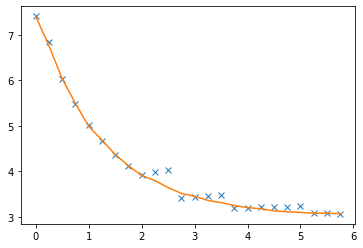

In [3]:
m = [12.267224,   12.20857123, 12.1378665,  12.0606479,  11.98048259, 11.89880288,
 11.81610567, 11.73385188, 11.65220462, 11.57089052, 11.4908133,  11.41186558,
 11.33358755, 11.25655926, 11.1808664,  11.10590293, 11.03189689, 10.95942312,
 10.8876618,  10.81659862, 10.74695516, 10.67815561, 10.60999983, 10.54266154]
z_range = [0., 0.25, 0.5,  0.75, 1., 1.25, 1.5,  1.75, 2.,   2.25, 2.5,  2.75, 3.,   3.25,
 3.5,  3.75, 4.,   4.25, 4.5,  4.75, 5.,   5.25, 5.5,  5.75]

c_old = np.zeros_like(z_range)
c_meta = np.zeros_like(z_range)

for i, z in enumerate(z_range):
    c_old[i] = getC(m[i], z, method = 'fix_z')
    c_meta[i] = getC(m[i], z, method = 'fix_m')
    
plt.figure()
plt.plot(z_range, c_old, 'x')
#plt.plot(z_range, c_new, 'x')
plt.plot(z_range, c_meta )



z=0 -> 13.786206419159683
This converted back to z:  -4.4127651514735966e-05


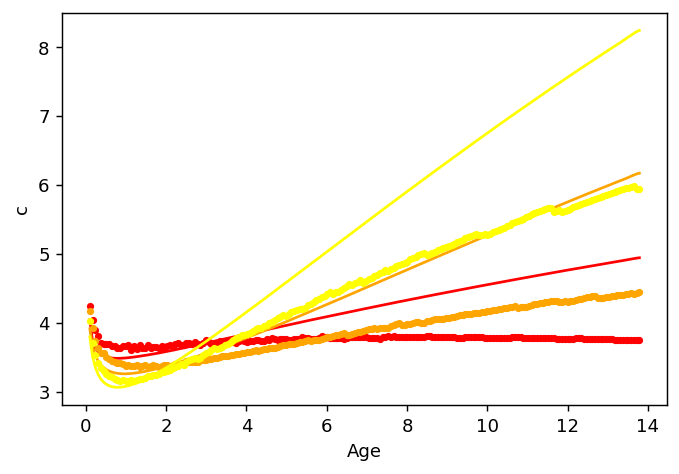

In [6]:
plt.figure(dpi=130)

masses = [15, 14, 13]
colours = ['red', 'orange', 'yellow']

steps = 200
t_range = np.linspace(cosmo.age(0), 0.1, steps)
z_range = cosmo.age(t_range, inverse=True)
z_range[z_range < 0] = 0 # As we can get very small negatives

var = cosmo.age(0)
print("z=0 ->", var )
print("This converted back to z: ", cosmo.age(var, inverse=True))

for i, mass in enumerate(masses):
    track = halo_growth.Mass_acc_history_VDB_FS(mass, z_range, cosmo.h, cosmo.Om0)
    c = getC(track, z_range, method = 'fix_m')
    plt.plot(t_range, c, '.', color = colours[i])
    plt.plot(t_range, concentration.concentration(cosmo.h*10**track, 
                                                  'vir', z_range, model = 'ishiyama20'),
            color = colours[i])
    
plt.xlabel("Age")
plt.ylabel("c")    
plt.show()

Age: 0.5 Gyr ABB, corresponding z: 9.574051945068764
File closest 10.0, divergence = 0.43


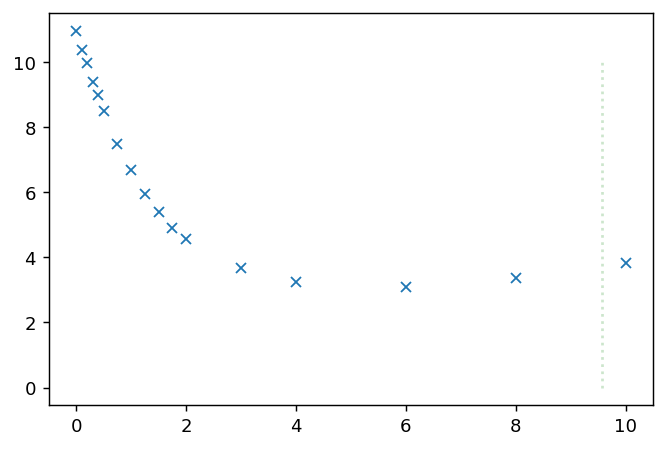

In [5]:
# -----
M0 = 15
# -----

###########
steps = 200
t_range = np.linspace(cosmo.age(0), 0.1, steps)
z_range = cosmo.age(t_range, inverse=True)
z_range[z_range < 0] = 0 # As we can get very small negatives
track = halo_growth.Mass_acc_history_VDB_FS(M0, z_range, cosmo.h, cosmo.Om0)
z2m = interp1d(z_range, track, 
               kind = 'quadratic',
               bounds_error = False, 
               fill_value = 'extrapolate')
############

# -------------------
interesting_age = 0.5 # Gyr
# -------------------

interesting_z = cosmo.age(interesting_age, inverse = True)
print("Age: {} Gyr ABB, corresponding z: {}".format(interesting_age, interesting_z))

z_target = find_nearest(np.unique(z_array), interesting_z)
print("File closest {}, divergence = {:.2}".format(z_target, abs(interesting_z-z_target)))
#find_nearest(array, value):

width = 0.5
m = z2m(interesting_z)
mask = (M200cl > m-width/2 ) & (M200cl < m+width/2)
zs = z_array[mask]
uniquez = np.unique(zs)
meanC = np.zeros_like(uniquez)
for i, zi in enumerate(uniquez):
    meanC[i] = np.mean(c200c[mask & (z_array == zi)])
    
plt.figure(dpi = 130)
plt.plot(uniquez, meanC, 'x')
plt.plot([interesting_z, interesting_z], [0, 10], "g:", alpha = 0.2)
plt.show()

